# Forecasting electrical grid transformer loads
# Tristan Looden 02-03-2025

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from xgboost import XGBRegressor, XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, mean_squared_error
import datetime


sns.set_style('white')

In [26]:
df =  pd.read_pickle('../data/Case_Dataset.pkl')

In [27]:
# Choose forecasting domain
forecast_horizons = range(1,96)

## descriptives



In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90122 entries, 2021-04-02 10:15:00+00:00 to 2023-11-05 23:00:00+00:00
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transformer_load  90122 non-null  float64
 1   radiation         90119 non-null  float64
 2   windspeed_10m     90119 non-null  float64
 3   windspeed_100m    90119 non-null  float64
 4   windspeed_squall  90119 non-null  float64
 5   nedu_e1a          90122 non-null  float64
 6   nedu_e1b          90122 non-null  float64
 7   nedu_e1c          90122 non-null  float64
 8   nedu_e2a          90122 non-null  float64
 9   nedu_e2b          90122 non-null  float64
 10  nedu_e3a          90122 non-null  float64
 11  nedu_e3b          90122 non-null  float64
 12  nedu_e3c          90122 non-null  float64
 13  nedu_e3d          90122 non-null  float64
 14  nedu_e4a          90122 non-null  float64
dtypes: float64(15)
memory usage: 11.0 MB


In [29]:
df.head()

,transformer_load,radiation,windspeed_10m,windspeed_100m,windspeed_squall,nedu_e1a,nedu_e1b,nedu_e1c,nedu_e2a,nedu_e2b,nedu_e3a,nedu_e3b,nedu_e3c,nedu_e3d,nedu_e4a
2021-04-02 10:15:00+00:00,0.314834,2362538.0,7.087363,8.304909,11.329289,0.000023,0.000017,0.000013,0.000029,0.000025,0.000045,0.000045,0.000045,0.000045,0.0
2021-04-02 10:30:00+00:00,0.455148,2395208.0,7.169058,8.406696,11.468938,0.000022,0.000016,0.000012,0.000029,0.000024,0.000044,0.000044,0.000044,0.000044,0.0
2021-04-02 10:45:00+00:00,0.492845,2427878.0,7.250822,8.508593,11.608627,0.000022,0.000015,0.000011,0.000028,0.000024,0.000043,0.000043,0.000043,0.000043,0.0
2021-04-02 11:00:00+00:00,0.479581,2460548.0,7.332652,8.610595,11.748355,0.000021,0.000014,0.000010,0.000028,0.000024,0.000043,0.000043,0.000043,0.000043,0.0
2021-04-02 11:15:00+00:00,0.512740,2471373.5,7.532573,8.868861,12.003352,0.000020,0.000013,0.000010,0.000028,0.000024,0.000043,0.000043,0.000043,0.000043,0.0


In [30]:
df.describe()

,transformer_load,radiation,windspeed_10m,windspeed_100m,windspeed_squall,nedu_e1a,nedu_e1b,nedu_e1c,nedu_e2a,nedu_e2b,nedu_e3a,nedu_e3b,nedu_e3c,nedu_e3d,nedu_e4a
count,90122.000000,9.011900e+04,90119.000000,90119.000000,90119.000000,90122.000000,90122.000000,90122.000000,90122.000000,90122.000000,90122.000000,90122.000000,90122.000000,90122.000000,90122.000000
mean,0.415224,5.150861e+05,4.661820,7.355531,7.955567,0.000028,0.000027,0.000027,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000027
std,0.207996,7.941373e+05,2.544169,3.454582,4.168576,0.000009,0.000013,0.000014,0.000006,0.000007,0.000011,0.000011,0.000011,0.000011,0.000030
min,0.000000,-2.720625e+02,0.009033,0.013995,0.059771,0.000014,0.000000,0.000000,0.000017,0.000009,0.000014,0.000014,0.000014,0.000014,0.000000
25%,0.247469,5.450448e-11,2.792512,4.975678,4.912684,0.000020,0.000019,0.000019,0.000023,0.000023,0.000019,0.000019,0.000019,0.000019,0.000000
50%,0.363002,3.963215e+04,4.296795,7.035952,7.341977,0.000027,0.000025,0.000024,0.000029,0.000027,0.000023,0.000023,0.000023,0.000023,0.000000
75%,0.547644,7.837728e+05,6.035251,9.324676,10.149324,0.000034,0.000036,0.000037,0.000032,0.000032,0.000037,0.000037,0.000037,0.000037,0.000060
max,2.143106,3.197917e+06,20.362995,28.985344,35.749813,0.000066,0.000076,0.000076,0.000047,0.000049,0.000057,0.000057,0.000057,0.000057,0.000060


In [31]:
df.corr()

,transformer_load,radiation,windspeed_10m,windspeed_100m,windspeed_squall,nedu_e1a,nedu_e1b,nedu_e1c,nedu_e2a,nedu_e2b,nedu_e3a,nedu_e3b,nedu_e3c,nedu_e3d,nedu_e4a
transformer_load,1.000000,0.310983,0.792002,0.688225,0.803967,0.014982,-0.173675,-0.200606,0.070762,-0.153446,0.184099,0.184099,0.184099,0.184099,-0.194562
radiation,0.310983,1.000000,0.057008,-0.210221,0.120948,-0.110961,-0.521475,-0.565887,0.187554,-0.342838,0.429468,0.429468,0.429468,0.429468,-0.594928
windspeed_10m,0.792002,0.057008,1.000000,0.919440,0.974461,0.092785,0.011275,-0.009304,0.134435,0.046113,0.170849,0.170849,0.170849,0.170849,-0.123603
windspeed_100m,0.688225,-0.210221,0.919440,1.000000,0.873585,0.111490,0.162728,0.157133,0.044515,0.126395,0.016650,0.016650,0.016650,0.016650,0.128961
windspeed_squall,0.803967,0.120948,0.974461,0.873585,1.000000,0.098651,-0.020261,-0.044009,0.162261,0.028282,0.200740,0.200740,0.200740,0.200740,-0.178628
nedu_e1a,0.014982,-0.110961,0.092785,0.111490,0.098651,1.000000,0.838706,0.805119,0.732509,0.725290,0.143220,0.143220,0.143220,0.143220,-0.081961
nedu_e1b,-0.173675,-0.521475,0.011275,0.162728,-0.020261,0.838706,1.000000,0.990218,0.476755,0.814651,-0.127456,-0.127456,-0.127456,-0.127456,0.263157
nedu_e1c,-0.200606,-0.565887,-0.009304,0.157133,-0.044009,0.805119,0.990218,1.000000,0.429652,0.798719,-0.184958,-0.184958,-0.184958,-0.184958,0.308712
nedu_e2a,0.070762,0.187554,0.134435,0.044515,0.162261,0.732509,0.476755,0.429652,1.000000,0.793583,0.695226,0.695226,0.695226,0.695226,-0.433444
nedu_e2b,-0.153446,-0.342838,0.046113,0.126395,0.028282,0.725290,0.814651,0.798719,0.793583,1.000000,0.347136,0.347136,0.347136,0.347136,-0.006114


## Basic QC


Three consecutive missing values in weather columns -> linear interpolation

Missing timestamps -> linear interpolation

suspected outlier in transformer_load -> linear interpolation

nedu_e3 columns are identical -> drop all but one

In [32]:
# check if index is sorted
is_sorted = df.index.is_monotonic_increasing
print(is_sorted)

True


In [33]:
df.isnull().sum()

transformer_load    0
radiation           3
windspeed_10m       3
windspeed_100m      3
windspeed_squall    3
nedu_e1a            0
nedu_e1b            0
nedu_e1c            0
nedu_e2a            0
nedu_e2b            0
nedu_e3a            0
nedu_e3b            0
nedu_e3c            0
nedu_e3d            0
nedu_e4a            0
dtype: int64

In [34]:
# check nan
missing_rows = df[df.isnull().any(axis=1)]
print(missing_rows)

                           transformer_load  radiation  windspeed_10m  \
2023-10-22 05:15:00+00:00          0.559860        NaN            NaN   
2023-10-22 05:30:00+00:00          0.619546        NaN            NaN   
2023-10-22 05:45:00+00:00          0.631414        NaN            NaN   

                           windspeed_100m  windspeed_squall  nedu_e1a  \
2023-10-22 05:15:00+00:00             NaN               NaN  0.000018   
2023-10-22 05:30:00+00:00             NaN               NaN  0.000019   
2023-10-22 05:45:00+00:00             NaN               NaN  0.000020   

                           nedu_e1b  nedu_e1c  nedu_e2a  nedu_e2b  nedu_e3a  \
2023-10-22 05:15:00+00:00  0.000022  0.000022  0.000025  0.000028  0.000018   
2023-10-22 05:30:00+00:00  0.000023  0.000024  0.000026  0.000029  0.000018   
2023-10-22 05:45:00+00:00  0.000024  0.000025  0.000027  0.000030  0.000018   

                           nedu_e3b  nedu_e3c  nedu_e3d  nedu_e4a  
2023-10-22 05:15:00+00:00  0.

In [35]:
#check duplication
df.duplicated().sum()

0

In [36]:
#find missing timestamps
freq = '15T'

# Generate full expected timestamp range
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)

# Find missing timestamps
missing_timestamps = full_range.difference(df.index)

print(missing_timestamps)
print(len(missing_timestamps))



DatetimeIndex(['2021-10-31 01:15:00+00:00', '2021-10-31 01:30:00+00:00',
               '2021-10-31 01:45:00+00:00', '2021-12-14 17:45:00+00:00',
               '2021-12-14 18:00:00+00:00', '2021-12-14 18:15:00+00:00',
               '2021-12-14 18:30:00+00:00', '2021-12-14 18:45:00+00:00',
               '2021-12-14 19:00:00+00:00', '2021-12-14 19:15:00+00:00',
               ...
               '2023-10-23 05:45:00+00:00', '2023-10-23 17:45:00+00:00',
               '2023-10-24 01:45:00+00:00', '2023-10-24 05:45:00+00:00',
               '2023-10-24 07:00:00+00:00', '2023-10-24 07:15:00+00:00',
               '2023-10-29 01:15:00+00:00', '2023-10-29 01:30:00+00:00',
               '2023-10-29 01:45:00+00:00', '2023-10-30 13:45:00+00:00'],
              dtype='datetime64[ns, UTC]', length=842, freq=None)
842


In [37]:
# enforce full data frequency
df = df.asfreq('15T') 

In [38]:
# interpolate the various missing values identified above
df.interpolate(method='linear', inplace=True)

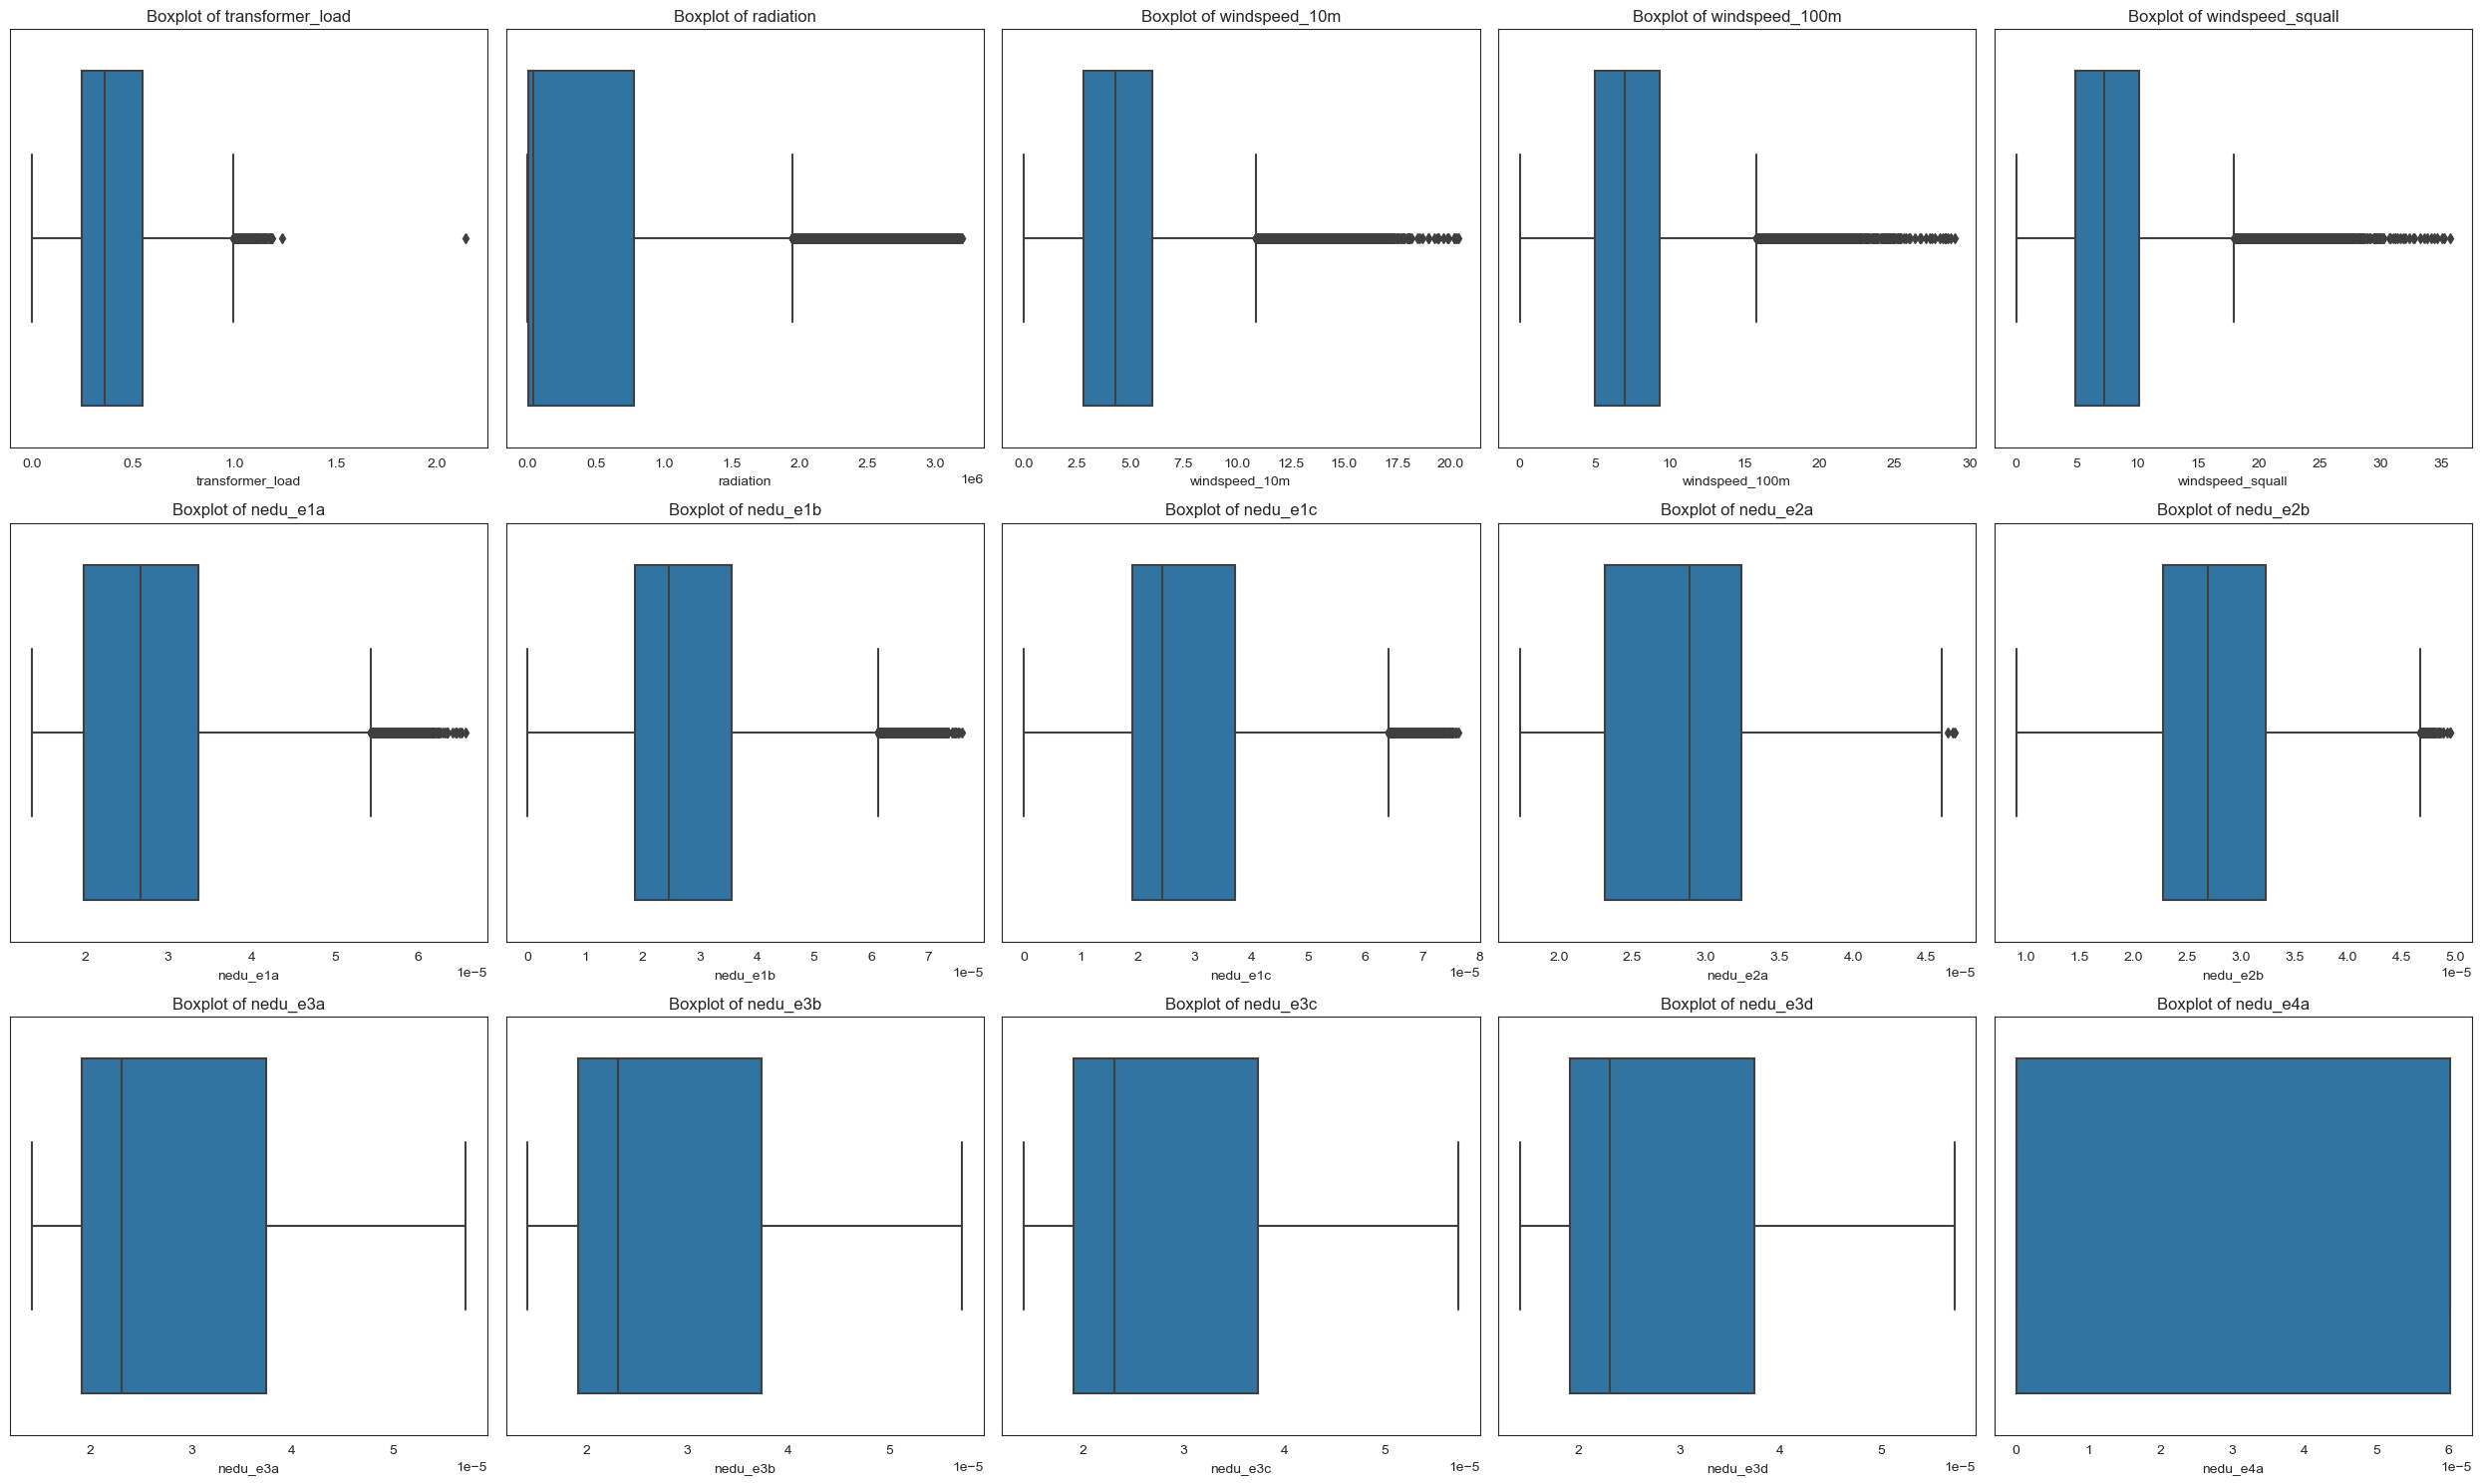

In [39]:
# plotting data distributions

# select num columns
num_cols = df.select_dtypes(include=['number']).columns

# define grid 
num_plots = len(num_cols)
cols = 5  
rows = math.ceil(num_plots / cols)  

# create subplots
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
axes = axes.flatten()

# loop through columns
for i, col in enumerate(num_cols):
    sns.boxplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")
    
plt.tight_layout()
plt.show()
#plt.savefig('/Users/tristan/Desktop/load_forecasting/figs/data_boxplot.pdf')

In [40]:
# find the row with the transformer outlier, display some rows around it.

max_index = df['transformer_load'].idxmax() 
max_loc = df.index.get_loc(max_index) 

num_surrounding = 2
start = max(0, max_loc - num_surrounding)
end = min(len(df), max_loc + num_surrounding + 1)

surrounding_rows = df.iloc[start:end]
print(surrounding_rows)

                           transformer_load      radiation  windspeed_10m  \
2022-08-29 17:45:00+00:00          0.301920  136772.390625       3.861528   
2022-08-29 18:00:00+00:00          0.301920   44436.000000       2.323129   
2022-08-29 18:15:00+00:00          2.143106   33327.000000       2.606496   
2022-08-29 18:30:00+00:00          0.301920   22218.000000       2.889900   
2022-08-29 18:45:00+00:00          0.240489   11109.000000       3.173331   

                           windspeed_100m  windspeed_squall  nedu_e1a  \
2022-08-29 17:45:00+00:00        6.326876          5.998669  0.000035   
2022-08-29 18:00:00+00:00        4.945013          4.650440  0.000035   
2022-08-29 18:15:00+00:00        5.542367          4.634052  0.000035   
2022-08-29 18:30:00+00:00        6.147220          4.709869  0.000035   
2022-08-29 18:45:00+00:00        6.757558          4.873588  0.000035   

                           nedu_e1b  nedu_e1c  nedu_e2a  nedu_e2b  nedu_e3a  \
2022-08-29 17:45:00

In [41]:
# linear interpolation for transformator outlier
col_name='transformer_load'
df.loc[max_index, col_name] = None
df[col_name] = df[col_name].interpolate(method='linear')

In [42]:
# drop duplicate nedu columns
drop_columns = ['nedu_e3b', 'nedu_e3c', 'nedu_e3d']  
df = df.drop(columns=drop_columns)

## Feature engineering

rate of change in load

weekend

day and year cycles

lags

ewmas

In [43]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90964 entries, 2021-04-02 10:15:00+00:00 to 2023-11-05 23:00:00+00:00
Freq: 15T
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transformer_load  90964 non-null  float64
 1   radiation         90964 non-null  float64
 2   windspeed_10m     90964 non-null  float64
 3   windspeed_100m    90964 non-null  float64
 4   windspeed_squall  90964 non-null  float64
 5   nedu_e1a          90964 non-null  float64
 6   nedu_e1b          90964 non-null  float64
 7   nedu_e1c          90964 non-null  float64
 8   nedu_e2a          90964 non-null  float64
 9   nedu_e2b          90964 non-null  float64
 10  nedu_e3a          90964 non-null  float64
 11  nedu_e4a          90964 non-null  float64
dtypes: float64(12)
memory usage: 11.0 MB


In [44]:
df_aug = df.copy()

# rate of change in load
df_aug['load_delta'] = df_aug['transformer_load'].diff()
df_aug['load_ewma_4'] = df_aug['load_delta'].ewm(span=4, adjust=False).mean()

# weekend
df_aug['is_weekend'] = (df_aug.index.dayofweek >= 5).astype(int) 

# fourier features for day-cycle and year-cycle
df_aug['sin_day'] = np.sin(2 * np.pi * df_aug.index.hour / 24)
df_aug['cos_day'] = np.cos(2 * np.pi * df_aug.index.hour / 24)
df_aug['sin_year'] = np.sin(2 * np.pi * df_aug.index.dayofyear / 365)
df_aug['cos_year'] = np.cos(2 * np.pi * df_aug.index.dayofyear / 365)

# features to use for lags/ewma
lag_features = ['transformer_load', 'radiation', 'windspeed_10m','windspeed_100m','windspeed_squall']
#['transformer_load', 'radiation', 'windspeed_10m','windspeed_100m','windspeed_squall','nedu_e1a','nedu_e1b', 'nedu_e1c','nedu_e2a','nedu_e2b','nedu_e3a','nedu_e4a']

"""
# lags
lags = [96]                
for f in lag_features:
    for l in lags:
        df_aug[f+'_lag_'+str(l)] = df_aug[f].shift(l)
"""
# EWMA
ewmas = [16, 192]                
for f in lag_features:
    for e in ewmas:
        df_aug[f+'_ewma_'+str(e)] = df_aug[f].ewm(span=e, adjust=False).mean()


# drop all nedu
drop_columns = ['nedu_e1a', 'nedu_e3a','nedu_e1b','nedu_e1c','nedu_e2a','nedu_e2b','nedu_e4a','windspeed_10m']  
df_aug = df_aug.drop(columns=drop_columns)

In [45]:
df_aug.corr()

,transformer_load,radiation,windspeed_100m,windspeed_squall,load_delta,load_ewma_4,is_weekend,sin_day,cos_day,sin_year,...,transformer_load_ewma_16,transformer_load_ewma_192,radiation_ewma_16,radiation_ewma_192,windspeed_10m_ewma_16,windspeed_10m_ewma_192,windspeed_100m_ewma_16,windspeed_100m_ewma_192,windspeed_squall_ewma_16,windspeed_squall_ewma_192
transformer_load,1.000000,0.311461,0.688889,0.805056,0.084853,0.184377,0.023647,0.054431,-0.282761,0.168136,...,0.934760,0.643848,0.281398,-0.035361,0.781179,0.575175,0.693586,0.554760,0.774304,0.560236
radiation,0.311461,1.000000,-0.210303,0.122396,0.041231,0.108449,0.007508,0.185101,-0.641387,0.099454,...,0.217107,-0.023067,0.900462,0.455058,-0.000154,-0.118111,-0.219556,-0.188926,0.043431,-0.105799
windspeed_100m,0.688889,-0.210303,1.000000,0.873152,0.015491,0.038639,-0.014933,-0.036636,0.044597,0.048848,...,0.705713,0.599977,-0.215459,-0.317982,0.898441,0.709561,0.965863,0.741576,0.853461,0.684176
windspeed_squall,0.805056,0.122396,0.873152,1.000000,-0.003285,0.020259,-0.016336,-0.003961,-0.255524,0.089139,...,0.815083,0.612626,0.119652,-0.141589,0.960076,0.707171,0.868871,0.679987,0.958517,0.699818
load_delta,0.084853,0.041231,0.015491,-0.003285,1.000000,0.802651,0.000298,0.108801,0.018372,-0.000280,...,-0.090113,-0.054851,-0.042967,-0.043182,-0.032815,-0.033521,-0.014115,-0.022912,-0.049307,-0.036441
load_ewma_4,0.184377,0.108449,0.038639,0.020259,0.802651,1.000000,0.000771,0.201819,0.012562,-0.000336,...,-0.108028,-0.094587,-0.044918,-0.073198,-0.041002,-0.059154,-0.014966,-0.040528,-0.071078,-0.065053
is_weekend,0.023647,0.007508,-0.014933,-0.016336,0.000298,0.000771,1.000000,0.000294,0.000032,0.000111,...,0.024954,0.021259,0.008306,0.006294,-0.012009,0.010489,-0.015502,0.007560,-0.016524,0.006430
sin_day,0.054431,0.185101,-0.036636,-0.003961,0.108801,0.201819,0.000294,1.000000,-0.000034,-0.000640,...,-0.070729,-0.065681,-0.111899,-0.207534,-0.063955,-0.042982,-0.012582,0.007424,-0.106609,-0.057417
cos_day,-0.282761,-0.641387,0.044597,-0.255524,0.018372,0.012562,0.000032,-0.000034,1.000000,-0.000186,...,-0.266562,-0.026247,-0.658213,-0.106250,-0.172165,-0.012782,0.051536,0.009221,-0.212694,-0.010439
sin_year,0.168136,0.099454,0.048848,0.089139,-0.000280,-0.000336,0.000111,-0.000640,-0.000186,1.000000,...,0.181981,0.263844,0.112541,0.214317,0.107625,0.153371,0.051313,0.075499,0.094048,0.134788


In [46]:
def create_supervised_data(df, horizon=1, binary=False):
    '''Create X, y datasets for given forecast horizon.'''

    data = df.copy()

    # shift target attached data
    #cols_to_shift = ['is_weekend', 'sin_day', 'cos_day', 'sin_year', 'cos_year']
    #data[cols_to_shift] = data[cols_to_shift].shift(-horizon)

    # shift target
    data['y_future'] = data['transformer_load'].shift(-horizon)

    # Drop nan rows
    data.dropna(inplace=True)

    X = data.drop(columns=['y_future'])  
    
    if binary == True:
        y = data['exceed'] = (data['y_future'] > 1).astype(int)
    else:
        y = data['y_future']
        
    return X, y

## xgboost regression model training

In [47]:
models = {}
r2_scores = {}
rmse_scores = {}
mae_scores = {}

for horizon in forecast_horizons:
    # create supervised dataset for horizon
    X, y = create_supervised_data(df_aug, horizon=horizon)

    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  

    # train  model
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
    model.fit(X_train, y_train)
    
    # evaluate model
    score = model.score(X_test, y_test)
    r2_scores[horizon]=score

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores[horizon] = rmse
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores[horizon] = mae

    print(f"Horizon={horizon}: R^2 = {score:.3f}")

    # save model
    models[horizon] = model

Horizon=1: R^2 = 0.973
Horizon=2: R^2 = 0.938
Horizon=3: R^2 = 0.910
Horizon=4: R^2 = 0.885
Horizon=5: R^2 = 0.860
Horizon=6: R^2 = 0.838
Horizon=7: R^2 = 0.817
Horizon=8: R^2 = 0.797
Horizon=9: R^2 = 0.775
Horizon=10: R^2 = 0.753
Horizon=11: R^2 = 0.732
Horizon=12: R^2 = 0.708
Horizon=13: R^2 = 0.698
Horizon=14: R^2 = 0.673
Horizon=15: R^2 = 0.661
Horizon=16: R^2 = 0.640
Horizon=17: R^2 = 0.621
Horizon=18: R^2 = 0.608
Horizon=19: R^2 = 0.597
Horizon=20: R^2 = 0.579
Horizon=21: R^2 = 0.561
Horizon=22: R^2 = 0.547
Horizon=23: R^2 = 0.537
Horizon=24: R^2 = 0.523
Horizon=25: R^2 = 0.519
Horizon=26: R^2 = 0.504
Horizon=27: R^2 = 0.488
Horizon=28: R^2 = 0.464
Horizon=29: R^2 = 0.462
Horizon=30: R^2 = 0.462
Horizon=31: R^2 = 0.449
Horizon=32: R^2 = 0.435
Horizon=33: R^2 = 0.426
Horizon=34: R^2 = 0.407
Horizon=35: R^2 = 0.413
Horizon=36: R^2 = 0.398
Horizon=37: R^2 = 0.388
Horizon=38: R^2 = 0.388
Horizon=39: R^2 = 0.372
Horizon=40: R^2 = 0.383
Horizon=41: R^2 = 0.374
Horizon=42: R^2 = 0.362
H

## xgboost classifier model training

In [48]:

models_bin = {}

precision_scores = {}
recall_scores = {}
accuracy_scores = {}

for horizon in forecast_horizons:
    # create supervised dataset for horizon
    X, y = create_supervised_data(df_aug, horizon=horizon, binary=True)

    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  

    # train  model
    model_bin = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, scale_pos_weight = 200, random_state=42)
    model_bin.fit(X_train, y_train)

    # evaluate model
    y_pred = model_bin.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    accuracy_scores[horizon]=acc
    precision_scores[horizon]=prec
    recall_scores[horizon]=rec
    print(f"Horizon={horizon}: precision = {prec:.3f}, recall = {rec:.3f}")
    
    # save model
    models_bin[horizon] = model_bin

Horizon=1: precision = 0.652, recall = 0.876
Horizon=2: precision = 0.574, recall = 0.852
Horizon=3: precision = 0.498, recall = 0.698
Horizon=4: precision = 0.404, recall = 0.361
Horizon=5: precision = 0.390, recall = 0.272
Horizon=6: precision = 0.476, recall = 0.414
Horizon=7: precision = 0.335, recall = 0.349
Horizon=8: precision = 0.366, recall = 0.314
Horizon=9: precision = 0.329, recall = 0.284
Horizon=10: precision = 0.287, recall = 0.272
Horizon=11: precision = 0.237, recall = 0.225
Horizon=12: precision = 0.208, recall = 0.249
Horizon=13: precision = 0.181, recall = 0.189
Horizon=14: precision = 0.166, recall = 0.189
Horizon=15: precision = 0.155, recall = 0.201
Horizon=16: precision = 0.153, recall = 0.195
Horizon=17: precision = 0.143, recall = 0.231
Horizon=18: precision = 0.166, recall = 0.213
Horizon=19: precision = 0.137, recall = 0.166
Horizon=20: precision = 0.153, recall = 0.189
Horizon=21: precision = 0.083, recall = 0.112
Horizon=22: precision = 0.131, recall = 0.1

## model predictions

In [49]:
def multi_horizon_forecast(row_idx, models, forecast_horizons):
    """Generate multi-step forecasts"""

    target_row = df_aug.iloc[[row_idx]].copy() 
    
    predictions = {}
    predictions_bin= {}
        
    for horizon in forecast_horizons:  

        #augment with known future information
        target_row_idx = target_row.index[0]
        future_index= pd.date_range(start=target_row_idx, periods=horizon,freq=freq)[-1]
        target_row_aug=target_row.copy()
        # weekend
        target_row_aug['is_weekend'] = int(future_index.dayofweek >= 5)
        # fourier features for day-cycle and year-cycle
        target_row_aug['sin_day'] = np.sin(2 * np.pi * future_index.hour / 24)
        target_row_aug['cos_day'] = np.cos(2 * np.pi * future_index.hour / 24)
        target_row_aug['sin_year'] = np.sin(2 * np.pi * future_index.dayofyear / 365)
        target_row_aug['cos_year'] = np.cos(2 * np.pi * future_index.dayofyear / 365)
        
        # Predict using the horizon-specific regression model
        model = models[horizon]
        y_pred = model.predict(target_row_aug)  
        predictions[horizon] = y_pred[0]

        # Predict using the horizon-specific binary model
        model_bin = models_bin[horizon]
        y_pred = model_bin.predict_proba(target_row_aug)  
        predictions_bin[horizon] = y_pred[:,1][0]
        
    return predictions, predictions_bin

In [50]:
df_performance = pd.DataFrame({'horizon':list(r2_scores.keys()), 'r2':list(r2_scores.values()), 'mae':list(mae_scores.values()), 'rmse':list(rmse_scores.values()), 'accuracy':list(accuracy_scores.values()),'precision':list(precision_scores.values()), 'recall':list(recall_scores.values())})

## Plotting

### Regression model performance

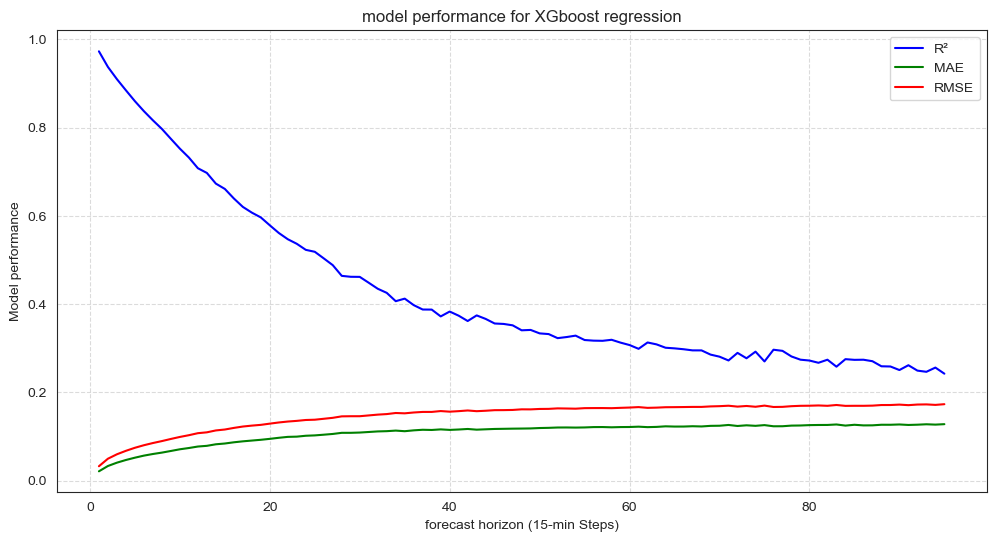

In [51]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_performance, x="horizon", y="r2", label="R²", color="blue")
sns.lineplot(data=df_performance, x="horizon", y="mae", label="MAE", color="green")
sns.lineplot(data=df_performance, x="horizon", y="rmse", label="RMSE", color="red")

plt.title("model performance for XGboost regression")
plt.xlabel("forecast horizon (15-min Steps)")
plt.ylabel("Model performance")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
#plt.savefig('/Users/tristan/Desktop/load_forecasting/figs/modelperformance_regression.pdf')
plt.show()

### Classifier model performance

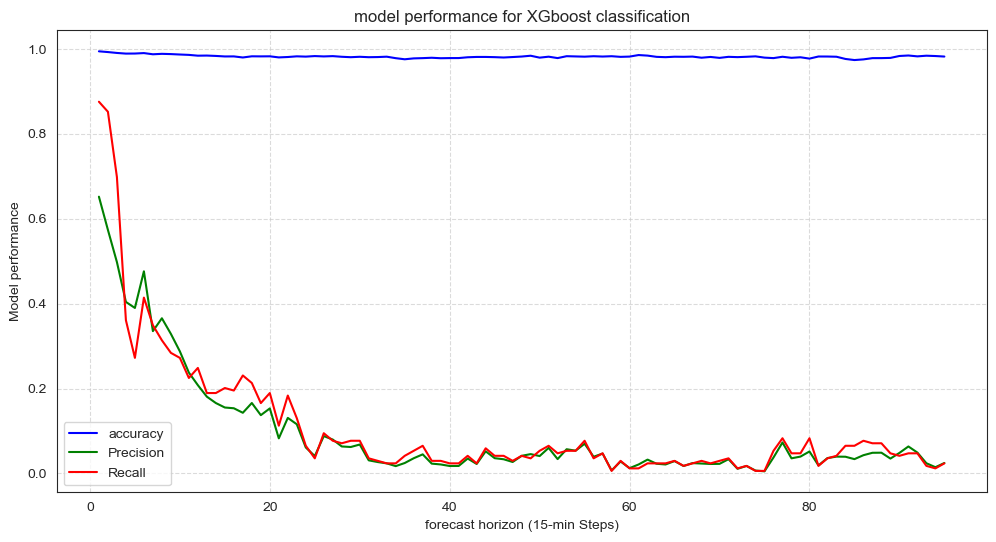

In [52]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_performance, x="horizon", y="accuracy", label="accuracy", color="blue")
sns.lineplot(data=df_performance, x="horizon", y="precision", label="Precision", color="green")
sns.lineplot(data=df_performance, x="horizon", y="recall", label="Recall", color="red")

plt.title("model performance for XGboost classification")
plt.xlabel("forecast horizon (15-min Steps)")
plt.ylabel("Model performance")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
#plt.savefig('/Users/tristan/Desktop/load_forecasting/figs/modelperformance_classifier.pdf')
plt.show()

### feature importance

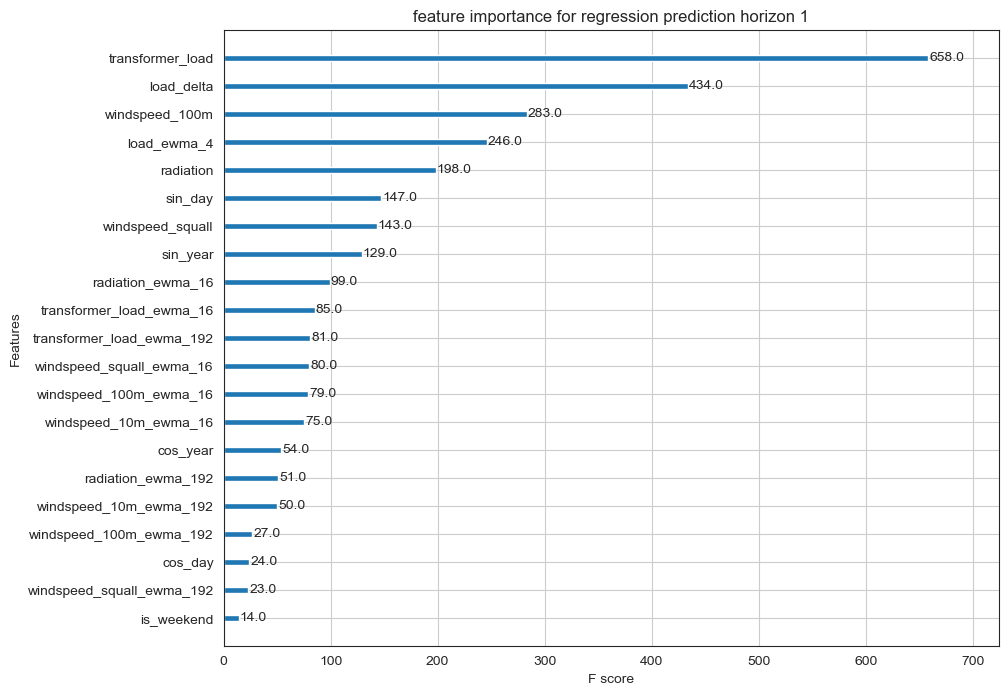

In [53]:
# feature importance

model_horizon=1

fig, ax = plt.subplots(figsize=(10, 8))  
plot_importance(models[model_horizon], ax = ax)
plt.title('feature importance for regression prediction horizon '+str(model_horizon) )
#plt.savefig('/Users/tristan/Desktop/load_forecasting/figs/featimpreg_'+str(model_horizon)+'.pdf', bbox_inches='tight')
plt.show()

### example prediction

In [54]:
exceed = np.where(df_aug['transformer_load']>=1)
print(exceed)

(array([  283,   284,   287,   288,   289,   290,   291,   494,  3017,
        3018,  3019,  3152,  3468,  4704,  4705,  4706,  4711,  4712,
        4713,  4716,  4887,  4890,  4891,  4892,  4893,  4894,  5194,
        5195,  9116, 11331, 11332, 11333, 11334, 12103, 12286, 12295,
       31484, 31487, 31488, 31489, 31490, 31507, 33694, 33696, 33697,
       33698, 33699, 33700, 33701, 33702, 33703, 33704, 33705, 33706,
       33707, 33708, 33709, 34955, 34956, 34957, 34958, 35424, 35425,
       35517, 35524, 35529, 37049, 37058, 37059, 37060, 37061, 37062,
       37349, 37351, 37352, 39268, 39269, 39270, 39271, 39272, 39273,
       39274, 39275, 39276, 39277, 39278, 39279, 39280, 39281, 39285,
       39286, 40032, 40122, 40123, 40124, 40125, 40126, 40127, 40128,
       40129, 40133, 40134, 40136, 40137, 40138, 40139, 40140, 40141,
       40230, 40231, 40232, 40233, 40238, 40239, 40240, 40241, 41273,
       41274, 41275, 45988, 45989, 45990, 45991, 45992, 45993, 45994,
       45995, 46001

In [78]:
row= 69300

preds, preds_bin = multi_horizon_forecast(row, models, forecast_horizons)

trueval={}
for i in forecast_horizons: 
    trueval[i] = df['transformer_load'].iloc[row + i]

In [79]:
# Convert dictionary to DataFrame
df_pred = pd.DataFrame.from_dict(preds, orient="index", columns=["prediction"])
df_pred.index.name = "horizon"
  # Convert index to column

df_pred['transformer load'] = trueval
df_pred['probability'] = preds_bin

df_pred.reset_index(inplace=True)

start_time = df.iloc[[row]].index[-1]  # Set your actual start time
df_pred["timestamp"] = start_time + pd.to_timedelta(df_pred["horizon"] * 15, unit="m")

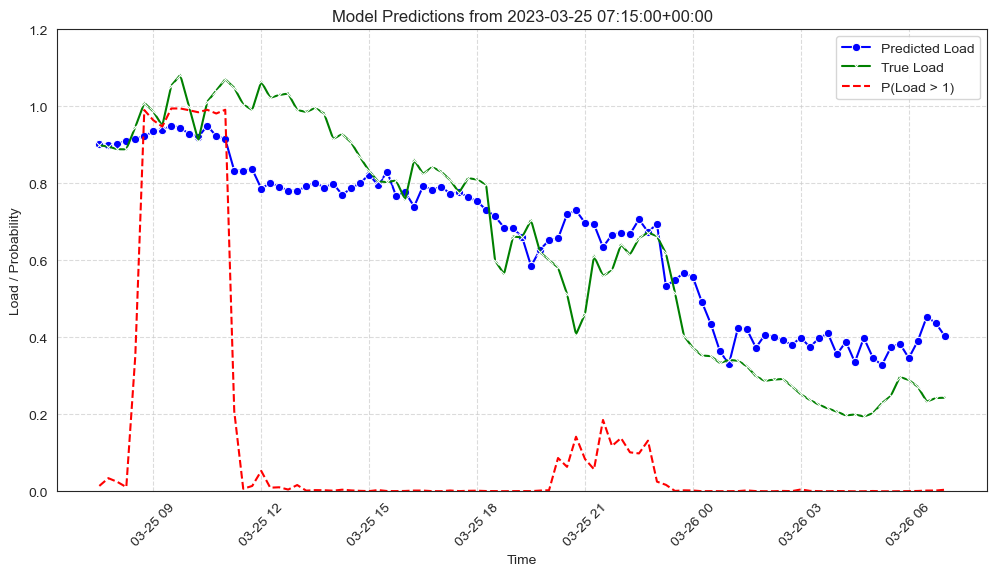

In [80]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# plot model predictions 
sns.lineplot(data=df_pred, x="timestamp", y="prediction", ax=ax1, marker="o", label="Predicted Load", color="blue")

# plot true values 
sns.lineplot(data=df_pred, x="timestamp", y="transformer load", ax=ax1, marker="x", label="True Load", color="green")

# plot probability
sns.lineplot(data=df_pred, x="timestamp", y="probability", ax=ax1, linestyle="dashed", color="red", label="P(Load > 1)")

# formatting 
ax1.set_xlabel("Time")
ax1.set_ylabel("Load / Probability")
ax1.set_ylim(0, 1.2)
ax1.legend(loc="upper right")

plt.title("Model Predictions from "+str(start_time))
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.grid(True, linestyle="--", alpha=0.7)  # Dashed gridlines for a cleaner look

#plt.savefig('/Users/tristan/Desktop/load_forecasting/figs/predplot_'+str(row)+'.pdf', bbox_inches='tight')
plt.show()

In [58]:
alert_timestamps = df_pred['timestamp'][df_pred['probability']>=0.5]
print('raise alert for following timestamps')
print(alert_timestamps)

raise alert for following timestamps
56   2023-07-25 18:30:00+00:00
Name: timestamp, dtype: datetime64[ns, UTC]
